# Images in (Solar) Astronomy

In this lesson we are going to look at aspects of processing and viewing images specific to Astronomy and Solar Astronomy. By the end of this lesson you should understand:

<section class="objectives panel panel-warning">
<div class="panel-heading">
<h3><span class="fa fa-certificate"></span> Learning Objectives </h3>
</div>
<ul>
    <li>Projected Coordinate Systems in Images</li>
    <li>World Coordinate Systems</li>
    <li>Using WCS to calculate coordinates in images</li>
    <li>Plotting images with WCS in images</li>
    <li>Using coordinates with SunPy Map</li>
</ul>
</section>

## Projected Coordinate Systems

<div style="float:left; width:39%">
<p>
When taking images of the sky, we are projecting the spherical celestial coordinate system onto a 2-dimensional plane, which means that there is no simple linear relation between pixel coordinates and celestial coordinates
</p>
<p>
There are multiple coordinate systems used to describe the locations in 2D and 3D space for both Astronomy and Solar Physics. We shall use a couple of these systems here as examples but if you want to know more about them there are many of resources avalible.
</p>
</div>
<div style="float:left; width:59%">
<img src="coord_inset.png" width=100% />
</div>

### Physical Coordinate Systems

Projected coordinate systems are one type of physical coordinate systems, they are the one we will be focusing on in this lesson due to their applicability to imaging data. Astropy and SunPy support representing point in many different physical coordinate systems, both projected and fully 3D, such as ICRS or Helioprojective.

In [1]:
import sunpy.coordinates
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
icrs = SkyCoord(10*u.deg, 86*u.deg, frame='icrs')
icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (10.0, 86.0)>

In [3]:
hpc = SkyCoord(100*u.arcsec, 700*u.arcsec, frame='helioprojective')
hpc

<SkyCoord (Helioprojective: D0=149597870.7 km, dateobs=None, L0=0.0 deg, B0=0.0 deg, rsun=695508.0 km): (Tx, Ty) in arcsec
    (100.0, 700.0)>

In [4]:
hpc.transform_to('heliographic_stonyhurst')

<SkyCoord (HeliographicStonyhurst: dateobs=None): (lon, lat, radius) in (deg, deg, km)
    (8.71644348, 46.69033505, 695508.0000057)>

### World Coordinate System

#### From pixels  to physical coordinates

The FITS files have a standard for describing the physical coordinate system associated with imaging data, this is called the world coordinate system or WCS, sometimes the specific FITS version of this is referred to as FITS-WCS.

There are multiple papers describing the FITS-WCS standard for various types of data, there is a list here: http://fits.gsfc.nasa.gov/fits_wcs.html

As you learned in the previous lesson we can load FITS files with Astropy. To demonstrate a simple example of a FITS file with FITS-WCS information in the header we shall use an image from SunPy:

In [5]:
from sunpy.data.sample import AIA_171_IMAGE
from astropy.io import fits

hdulist = fits.open(AIA_171_IMAGE)
hdulist.verify('silentfix')
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'SDO/JSOC-SDP'                                                        
DATE    = '2011-03-19T11:08:25'                                                 
TELESCOP= 'SDO/AIA'                                                             
INSTRUME= 'AIA_3'                                                               
DATE-OBS= '2011-03-19T10:54:

As you can see there are lots of keys in this and most other real world FITS headers. The ones we need to understand for FITS-WCS are:

Reference Pixel and Coordinate:

In [6]:
header = hdulist[0].header

print(header['CRVAL1'], header['CRVAL2'])
print(header['CRPIX1'], header['CRPIX2'])

0.0 0.0
512.5 512.5


Pixel resolution (at the reference pixel):

In [7]:
print(header['CDELT1'], header['CDELT2'])

2.4 2.4


Rotation angle, in degress (at the reference pixel):

In [8]:
print(header['CROTA2'])

0.0


Coordinate System and Projection:

In [9]:
print(header['CTYPE1'], header['CTYPE2'])

HPLN-TAN HPLT-TAN


We could now sit down and work out how to convert from a pixel coordinate to a physical coordinate described by this header (Helioprojective).

However, we can cheat and just use Astropy.

In [10]:
from astropy.wcs import WCS

wcs = WCS(header)

We can convert from pixel to world coordinate:

In [11]:
wcs.wcs_pix2world(((100, 100),), 0)

array([[  3.59725669e+02,  -2.74328093e-01]])

Or back again:

In [12]:
wcs.wcs_world2pix([[  3.59725669e+02,  -2.74328093e-01]], 0)

array([[ 100.00035549,   99.99999933]])

The last parameter to the two above examples is the 'origin' parameter. It is a flag that tells WCS if you indexes should be 0-based (like numpy) or 1-based (like FITS).
Here we are using 0 as we want to convert to and from numpy indexes of the array.

<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> How large is the image? </h2>
</div>
<br/>
To get a little practise using Astropy's WCS calculate the world coordinates of the following pixels:
<code>
[-500, 0]
[500, 500]
[0, 0]
</code>
<br/>
</section>

In [13]:
print(wcs.wcs_pix2world(((-500, 0),), 1))
print(wcs.wcs_pix2world(((500, 500),), 1))
print(wcs.wcs_pix2world(((0, 0),), 1))

[[  3.59325031e+02  -3.41638910e-01]]
[[  3.59991667e+02  -8.33333319e-03]]
[[  3.59658337e+02  -3.41656542e-01]]


### WCS and SkyCoord

A common usecase for WCS + Coordinates is to store or transform from pixel coordinates to one or more different physical coordinates. Combining Astropy WCS and Coordinates makes this easy.

For this part of the exercise we are going to use a CRISP cube, converted to FITS to have a correct header.

Assuming we have the WCS object we created from the FITS header above we can get an astropy Coordinate Frame:

In [14]:
from astropy.wcs.utils import wcs_to_celestial_frame

In [15]:
hpc_frame = wcs_to_celestial_frame(wcs)
hpc_frame

<Helioprojective Frame (D0=149597870.7 km, dateobs=2011-03-19 10:54:00.340000, L0=0.0 deg, B0=0.0 deg, rsun=695508.0 km)>

We can then use this when creating `SkyCoord` objects:

In [16]:
SkyCoord(100*u.arcsec, -500*u.arcsec, frame=hpc_frame)

<SkyCoord (Helioprojective: D0=149597870.7 km, dateobs=2011-03-19 10:54:00.340000, L0=0.0 deg, B0=0.0 deg, rsun=695508.0 km): (Tx, Ty) in arcsec
    (100.0, -500.0)>

*Note: For 2D solar data you should always use `sunpy.map` for this*

## Plotting with wcsaxes

In this section we are going to use the wcsaxes package to make WCS aware image plots.

In [17]:
import wcsaxes

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sunpy.cm

<IPython.core.display.Javascript object>


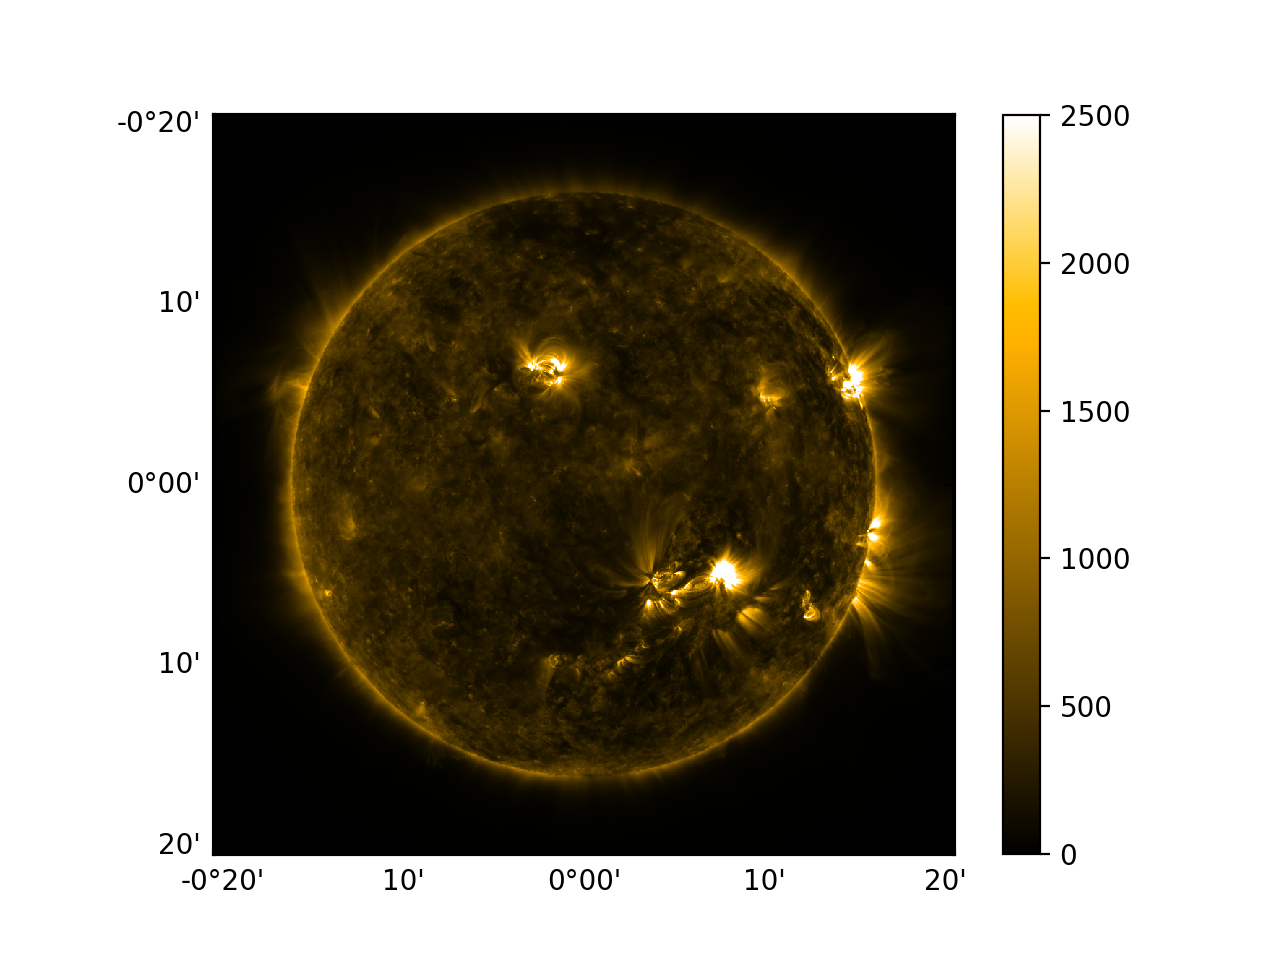

In [19]:
fig = plt.figure()
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdulist[0].data, cmap='sdoaia171', vmax=2500)
plt.colorbar(im)

<IPython.core.display.Javascript object>


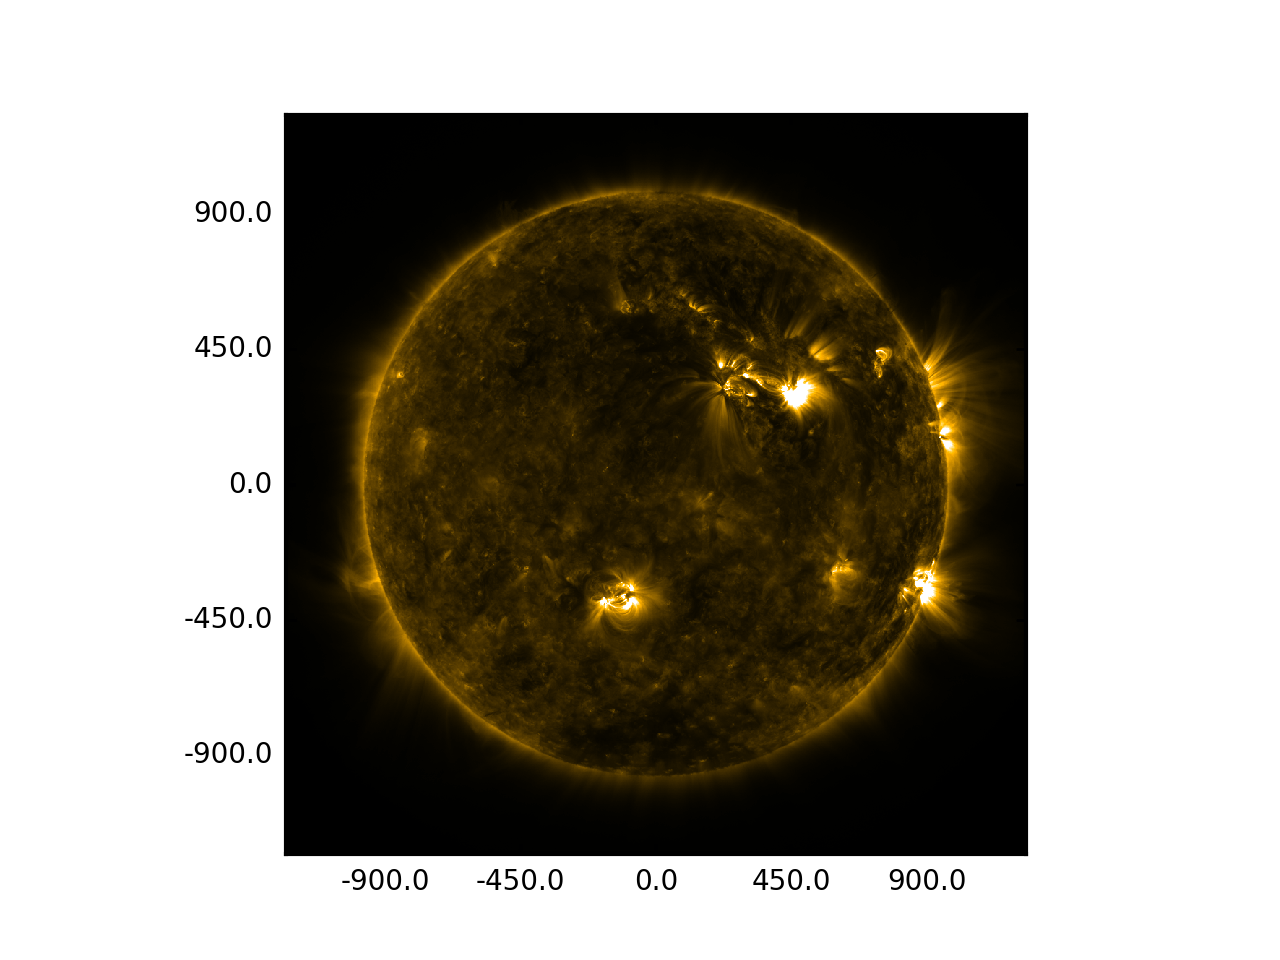

In [27]:
fig = plt.figure()
ax = plt.subplot(projection=wcs)

im = ax.imshow(hdulist[0].data, origin="lower", interpolation='none', cmap='sdoaia171', vmax=2500)

x, y = ax.coords

x.set_major_formatter("s.s")
y.set_major_formatter("s.s")

<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Add some labels </h2>
</div>
<br/>
Now we have a nice plot with physically meaningful ticks, we should label our axes.
<br/>
use `x.set_axislabel` and `y.set_axislabel` to set some labels for the AIA plot.
<br/>

Also overlay a coordinate grid using:
<a href="http://docs.astropy.org/en/stable/visualization/wcsaxes/overlaying_coordinate_systems.html"/><code>ax.coords.grid()</code></a>
Look up the documentation for this method to see what parameters you can specify.
<br/>
</section>

#### Solution

<IPython.core.display.Javascript object>


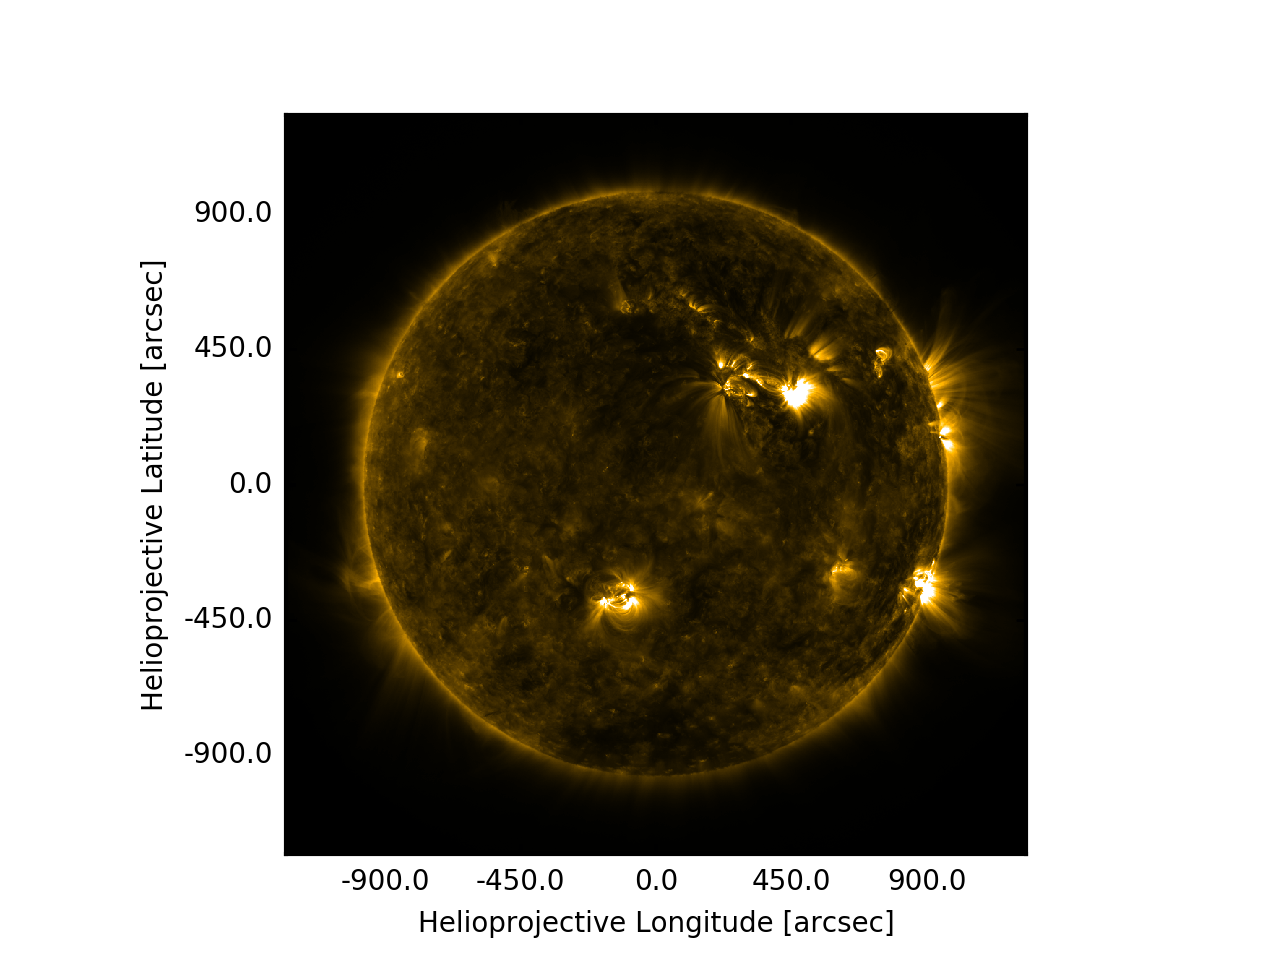

In [28]:
fig = plt.figure()
ax = plt.subplot(projection=wcs)

im = ax.imshow(hdulist[0].data, origin="lower", interpolation='none', cmap='sdoaia171', vmax=2500)

x, y = ax.coords

x.set_major_formatter("s.s")
y.set_major_formatter("s.s")

x.set_axislabel("Helioprojective Longitude [arcsec]")
y.set_axislabel("Helioprojective Latitude [arcsec]")

Now we have a nice plot, we can do a couple of things to plot.

### Overplotting in Pixel Coordinates

In [ ]:
ax = plt.subplot(111, projection=wcs)

ax.imshow(hdulist[0].data, cmap='gray', vmax=1000, interpolation=None, origin='lower')
ax.set_xlabel("Right Ascension [degrees]")
ax.set_ylabel("Declination [degrees]")
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')

ax.plot(3000, 3000, 'o')

### Overplotting in World Coordinates

In [ ]:
fig = plt.figure()
ax = plt.subplot(111, projection=wcs)

ax.imshow(hdulist[0].data, cmap='gray', vmax=1000, interpolation=None, origin='lower')
ax.set_xlabel("Right Ascension [degrees]")
ax.set_ylabel("Declination [degrees]")
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')

ax.set_autoscale_on(False)

ax.plot(3000, 3000, 'o')
# Overplot in FK5 in Degrees
ax.plot(189.25, 14.23, 'o', transform=ax.get_transform('fk5'))

## SunPy Map

The SunPy Map class is a wrapper for solar images which makes some of the above opertations easier.

<IPython.core.display.Javascript object>


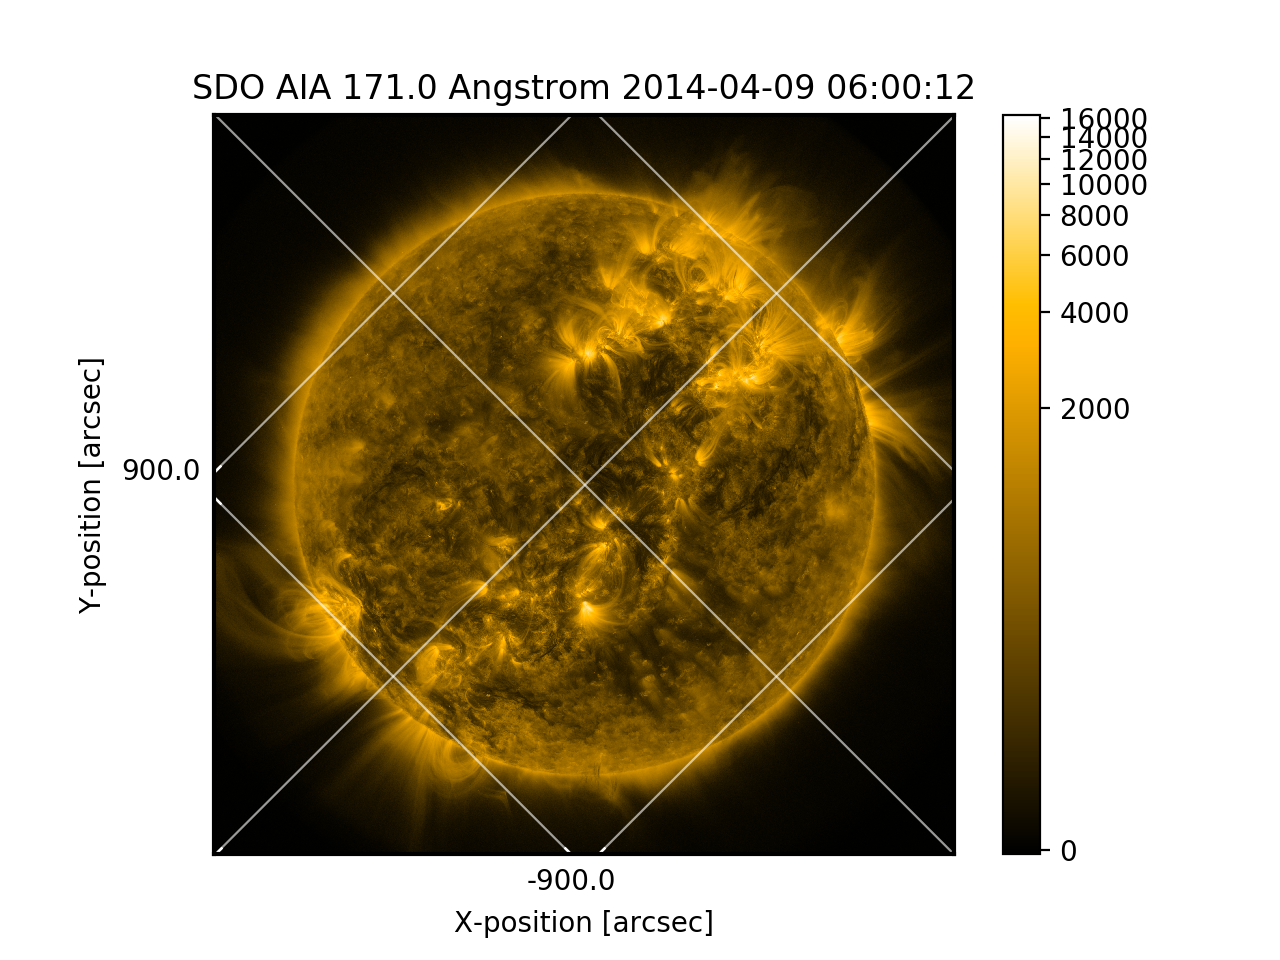

In [29]:
import sunpy.map
from sunpy.data.sample import AIA_171_ROLL_IMAGE

amap = sunpy.map.Map(AIA_171_ROLL_IMAGE)
amap.peek()

### Coordinate Systems

The SunPy map will calculate some of the things we did earlier automatically, and add some extra information.

In [30]:
amap.coordinate_system

Pair(x='HPLN-TAN', y='HPLT-TAN')

In [31]:
amap.coordinate_frame

<Helioprojective Frame (D0=149860273889.04 m, dateobs=2014-04-09 06:00:12.970000, L0=0.0 deg, B0=-6.047074 deg, rsun=695508.0 km)>

In [32]:
amap.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 2053.459961  2047.880005  
PC1_1 PC1_2  : 0.70734471922411957  0.70686876305701285  
PC2_1 PC2_2  : -0.70686876305701285  0.70734471922411957  
CDELT : 0.59948900000000005  0.59948900000000005  
NAXIS    : 0 0

### Overplotting in WCSAxes

<IPython.core.display.Javascript object>


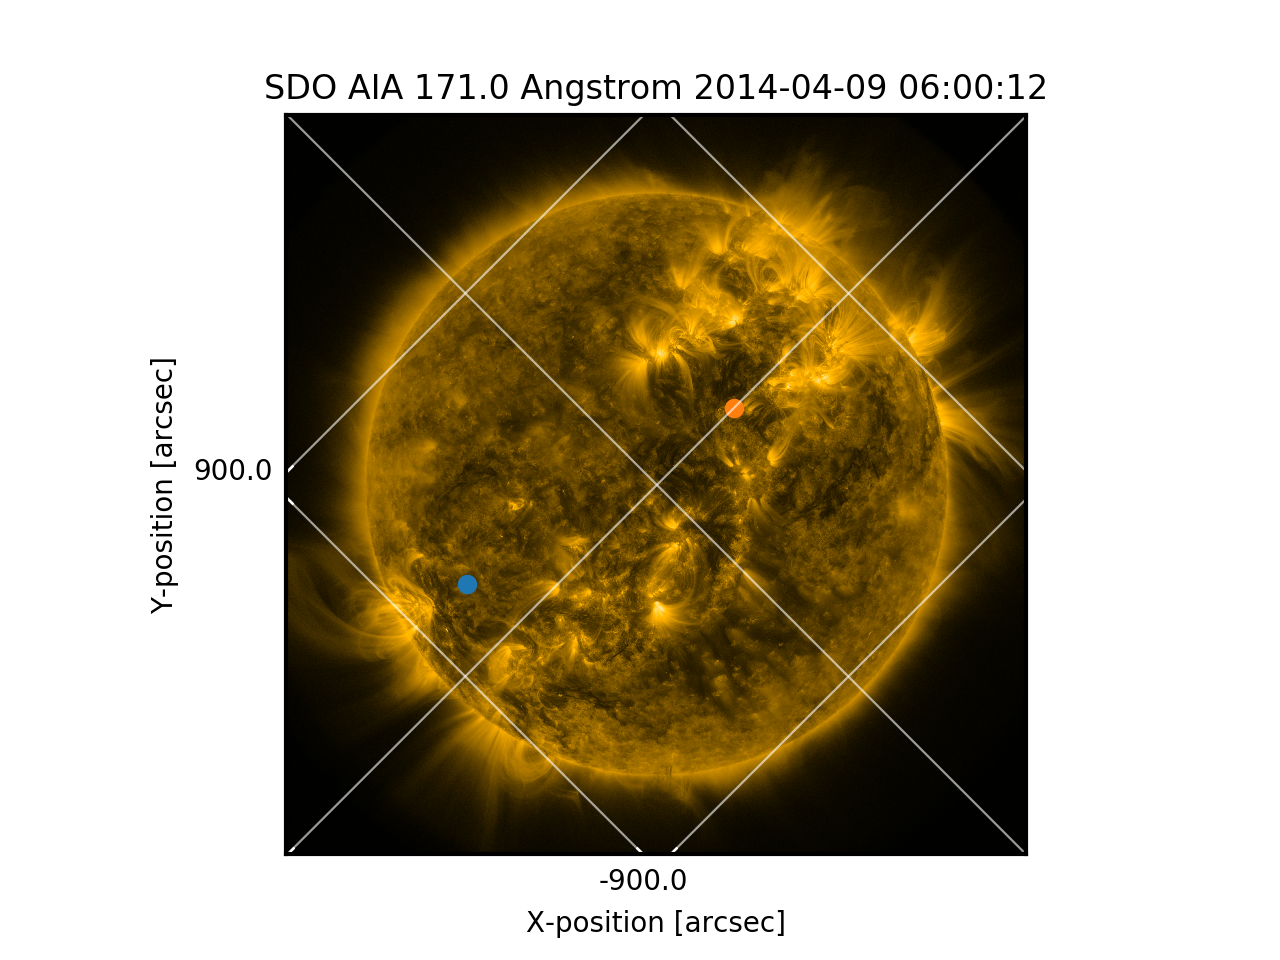

In [42]:
fig = plt.figure()
ax = plt.subplot(projection=amap)

im = amap.plot()

# Plotting is by default in pixels.
ax.plot(1000, 1500, 'o')

# Plotting in "world" coordinates is always in degrees.
ax.plot(0.1, 0, 'o', transform=ax.get_transform(amap.coordinate_frame))

## Three Dimensional Cubes 

Cube arrays are quite common in ground based and spectral type data, so we are going to use one as an example. SunPy has no wrapper class (like `Map`) for multi-dimensional data so this is an excellent way to use the things we have covered so far.

Download the file:

In [43]:
from astropy.utils.data import download_file

cube_file = download_file("http://data.sunpy.org/CRISP_LXY_Cube.fits.gz", cache=True)

Read in the cube FITS file

In [52]:
hdulist = fits.open(cube_file)
hdulist.info()

Filename: /home/stuart/.astropy/cache/download/py3/6e56a21864a7a489a3c6fdf872e26727
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      24   (1019, 1019, 32)   float32   


In [45]:
header = hdulist[0].header
data = hdulist[0].data

In [53]:
data.shape

(32, 1019, 1019)

Calculate the sun-earth distance when the observations were taken.

In [46]:
from sunpy import sun

In [47]:
wcs = WCS(header)
# Set the correct Sun-Earth distance
wcs.dsun = sun.sunearth_distance("2014-06-10T10:00:00").to(u.m)

In [48]:
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 6.5614239501953004e-07  0.24805555555556  -0.069444444444444003  
CRPIX : 0.0  509.0  509.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 8.6059570312500003e-12  1.6388888888889001e-05  1.6388888888889001e-05  
NAXIS    : 1019 1019

In [49]:
data.shape

(32, 1019, 1019)

In [50]:
sub = wcs.sub(axes=[2,3])

<IPython.core.display.Javascript object>


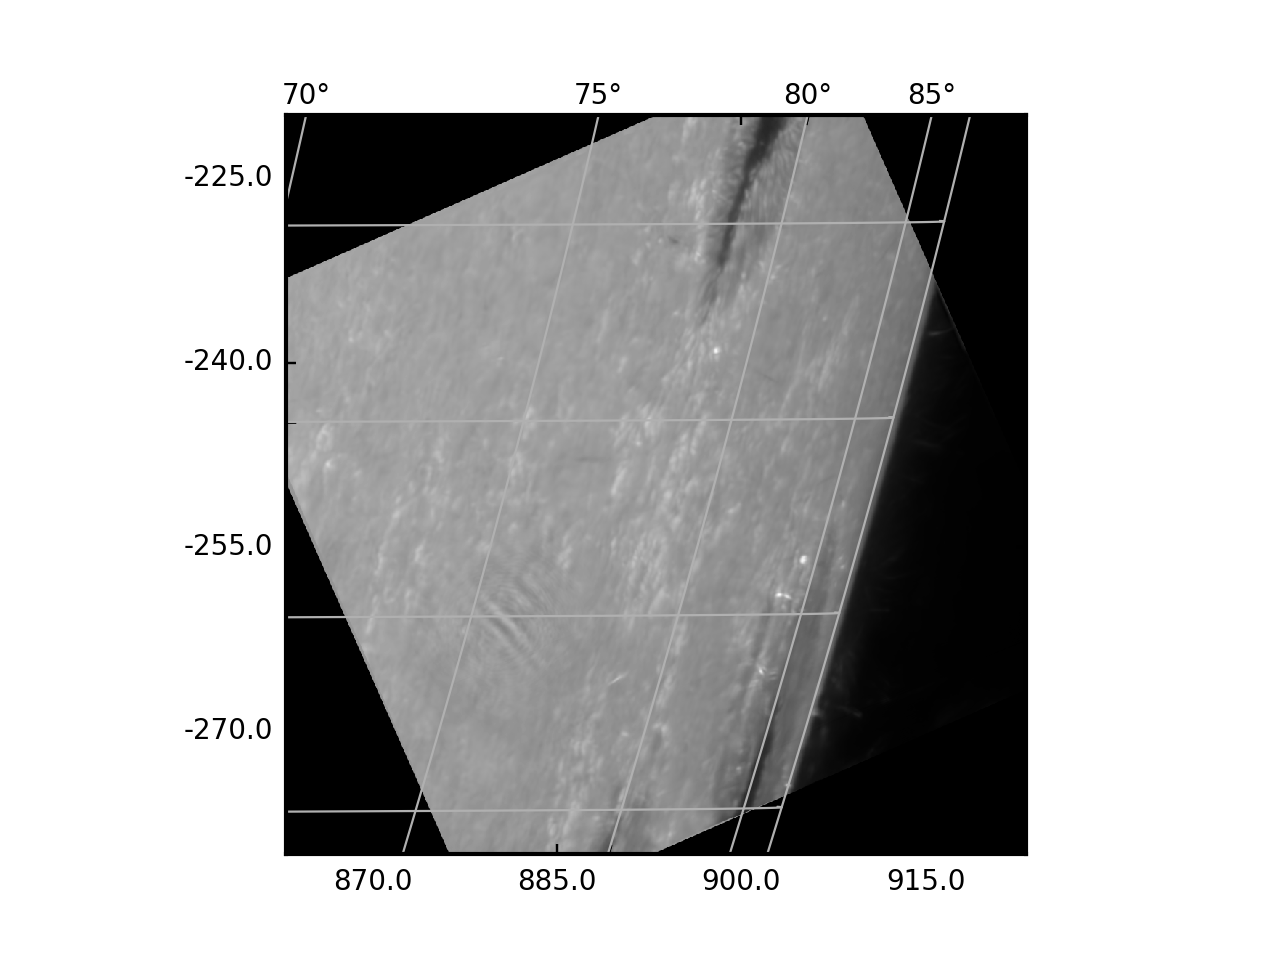

In [51]:
fig = plt.figure()
ax = plt.subplot(projection=sub)
ax.imshow(data[0], cmap='gray', interpolation='none', origin='lower')
lon, lat = ax.coords
lon.set_major_formatter('s.s')
lat.set_major_formatter('s.s')

overlay = ax.get_coords_overlay('heliographic_stonyhurst')
overlay.grid()